In [1]:
import Pkg
Pkg.activate(".")

  Activating project at `~/2024fall/BME574/Homework`


In [2]:
Pkg.add(["CairoMakie","LinearAlgebra","Distributions","Convex","SCS"])

   Resolving package versions...
  No Changes to `~/2024fall/BME574/Homework/Project.toml`
  No Changes to `~/2024fall/BME574/Homework/Manifest.toml`


In [3]:
using CairoMakie, LinearAlgebra, Statistics, Distributions, Convex, SCS

In [4]:
x = LinRange(-2,2,100); # performance of different regression methods were unstable with different range of x; in the range of [-2,2], lassow would performe better than least-square
A = reduce(hcat, [x .^p for p in 0:19]);
y_true = x .^ 2;

In [5]:
# function to fit least square fit using the pseudo-inverse of the design matrix
function fitlq(A,y)
    Ainv = pinv(A)
    return Ainv * y
end

# function to fit Lasso regression
function lasso(A,y,λ1)
    x = Variable(size(A)[2])
    problem = minimize(norm(A*x-y,2) + λ1*norm(x,1))
    solve!(problem, SCS.Optimizer; silent=true)
    return vec(evaluate(x))
end

lasso (generic function with 1 method)

In [6]:
# Initialize arrays to store coefficients and errors
n_rounds = 100;
B_ls = zeros(20, n_rounds);  # Least squares coefficients
B_lasso = zeros(20, n_rounds);  # Lasso coefficients
E_ls = zeros(n_rounds);  # Least squares errors
E_lasso = zeros(n_rounds);  # Lasso errors

In [7]:
# Perform 100 rounds of fitting
for i in 1:n_rounds
    # Add noise to true function
    y_noisy = y_true .+ rand(Normal(0,0.1), length(y_true))
    
    # Least squares fit
    b_ls = fitlq(A, y_noisy)
    B_ls[:,i] = b_ls
    y_ls = A * b_ls
    E_ls[i] = norm(y_true - y_ls) / norm(y_true)
    
    # Lasso fit
    b_lasso = lasso(A, y_noisy, 0.1)  # λ1=0.1
    B_lasso[:,i] = b_lasso
    y_lasso = A * b_lasso
    E_lasso[i] = norm(y_true - y_lasso) / norm(y_true)
end

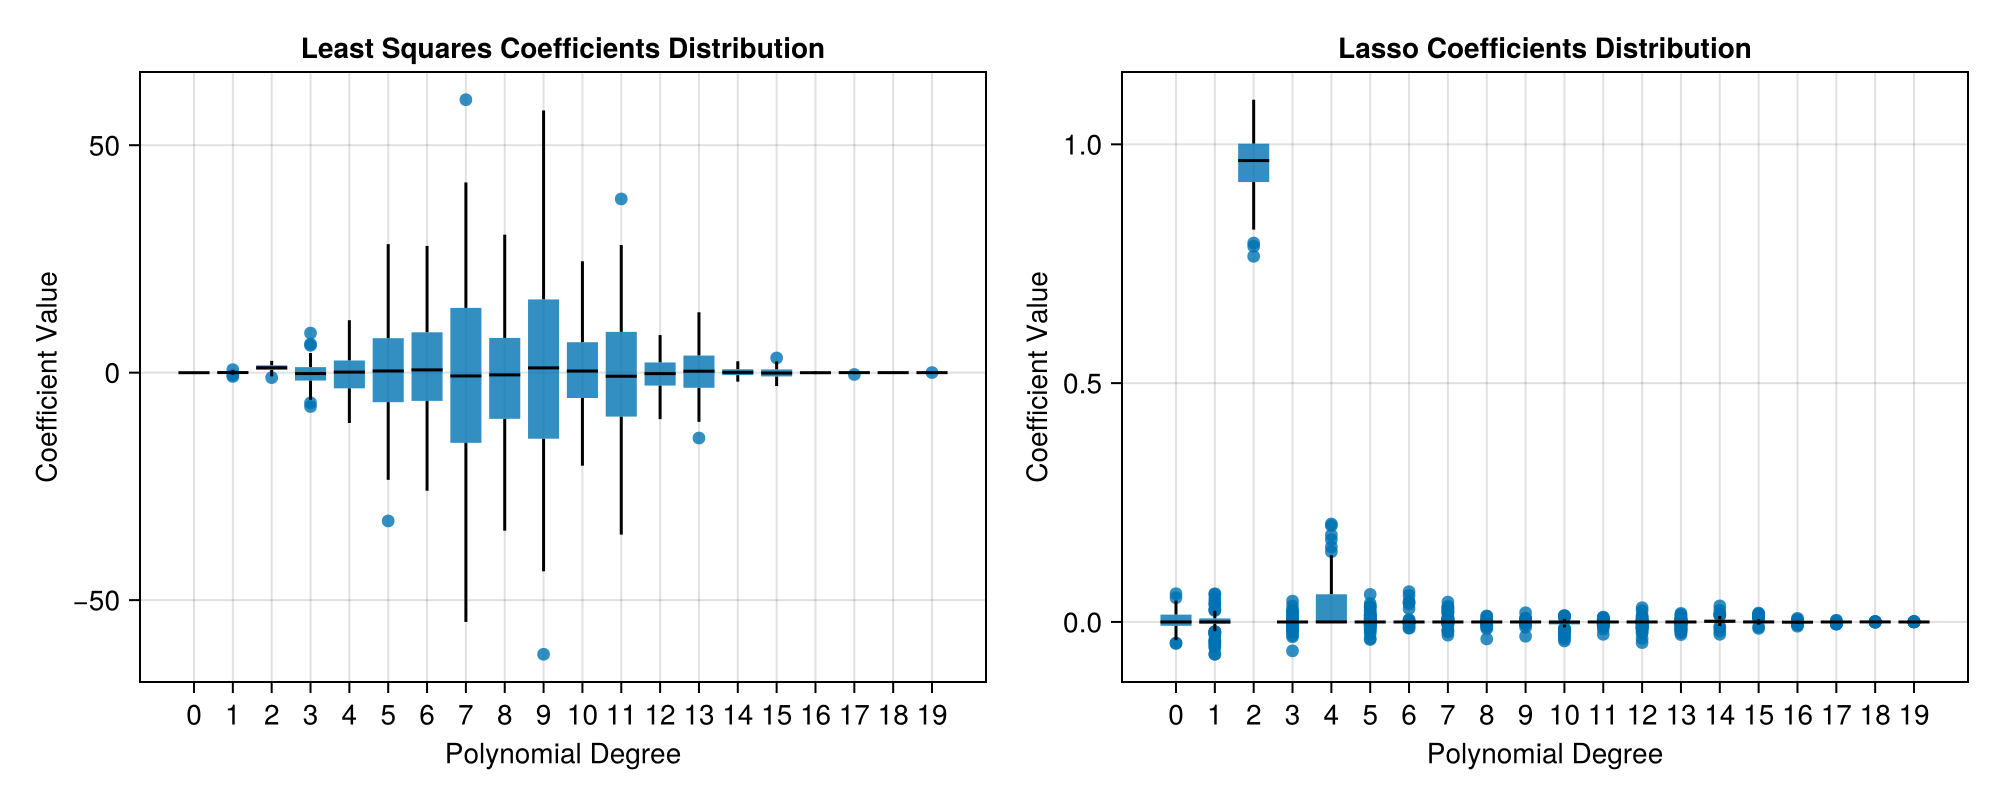

In [8]:
# Create figure with two subplots
fig = Figure(size=(1000, 400))

# Least Squares plot
ax1 = Axis(fig[1,1],
    title="Least Squares Coefficients Distribution",
    xlabel="Polynomial Degree",
    ylabel="Coefficient Value",
    xticks = 0:19)

categories = repeat(0:19, inner=n_rounds)
values_ls = vec(B_ls')
boxplot!(ax1, categories, values_ls)

# Lasso plot
ax2 = Axis(fig[1,2],
    title="Lasso Coefficients Distribution",
    xlabel="Polynomial Degree",
    ylabel="Coefficient Value",
    xticks = 0:19)

values_lasso = vec(B_lasso')
boxplot!(ax2, categories, values_lasso)

fig

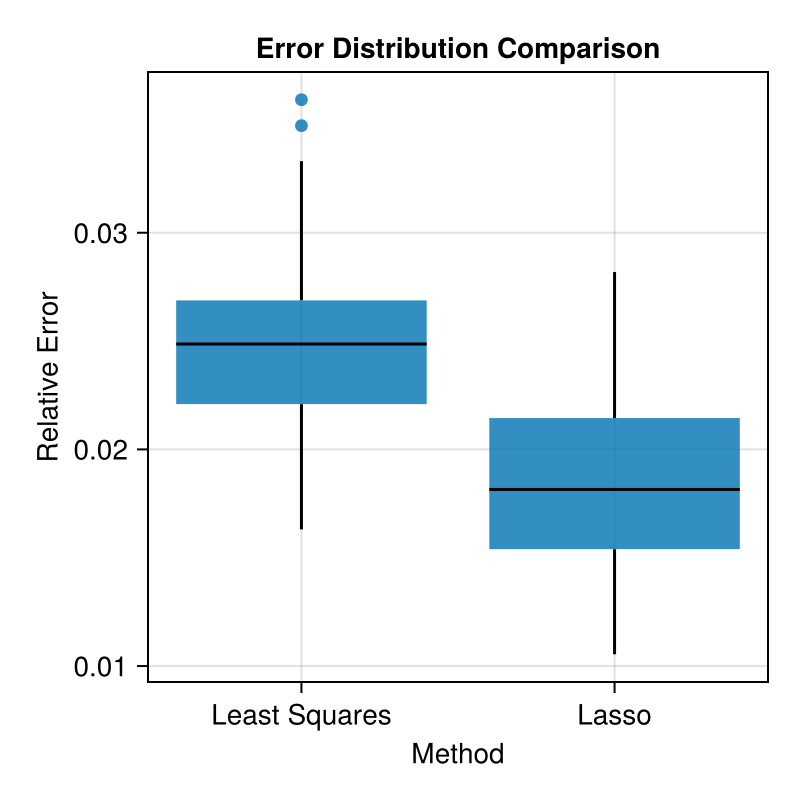

In [9]:
# Create figure for error distribution
fig = Figure(size=(400, 400))
ax = Axis(fig[1,1],
    title="Error Distribution Comparison",
    xlabel="Method",
    ylabel="Relative Error",
    xticks = (1:2, ["Least Squares", "Lasso"]))

# Plot errors using numerical positions
boxplot!(ax, repeat([1,2], inner=n_rounds), [E_ls; E_lasso])

fig